# Brain Tumor Segmentation: Baseline vs Optimized ResUNet (PyTorch)

## Complete Project Walkthrough

This notebook demonstrates the complete pipeline for brain tumor segmentation using ResUNet architecture with Tversky Loss optimization via Optuna.

**Project Structure:**
- `src/dataset.py`: Data loading and patient-wise splitting
- `src/model_utils.py`: ResUNet architecture, Tversky loss, metrics
- `src/paper_plots.py`: Publication-ready visualizations

## Step 1: Setup and Imports

Import required libraries (PyTorch, NumPy, Matplotlib, Optuna), set random seeds for reproducibility, configure GPU device, and create necessary directories for models and results.

In [16]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('..')

# Import custom modules
from src.dataset import (
    load_data_paths, 
    split_patients, 
    create_data_loaders,
    analyze_dataset_distribution
)
from src.model_utils import (
    ResUNet,
    TverskyLoss,
    count_parameters,
    train_model,
    validate,
    calculate_dice_per_sample
)
from src.paper_plots import (
    plot_patient_split,
    plot_slice_distribution,
    plot_training_history,
    plot_model_comparison_boxplot,
    visualize_segmentation_contest,
    plot_optuna_optimization
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)

print("=" * 70)
print("BRAIN TUMOR SEGMENTATION PROJECT (PyTorch)")
print("Comparing Baseline vs Optimized ResUNet")
print("=" * 70)

Using device: cuda
GPU: NVIDIA GeForce RTX 4060
GPU Memory: 8.59 GB
BRAIN TUMOR SEGMENTATION PROJECT (PyTorch)
Comparing Baseline vs Optimized ResUNet


## Step 2: Load Data and Perform Patient-Wise Split

Load image and mask paths from the LGG-MRI dataset, perform patient-wise splitting (70% train, 15% validation, 15% test) to prevent data leakage, analyze slice distributions across splits, and visualize patient distribution.

In [2]:
print("\n" + "=" * 70)
print("STEP 1: LOADING DATA AND PATIENT-WISE SPLITTING")
print("=" * 70 + "\n")

# Specify your data directory
DATA_DIR = '../data/kaggle_3m'  # Adjust this path

# Load data
image_paths, mask_paths, patient_groups = load_data_paths(DATA_DIR)

# Split patients (NO DATA LEAKAGE)
train_idx, val_idx, test_idx, train_patients, val_patients, test_patients = split_patients(
    patient_groups,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    random_state=42
)

# Analyze distributions
print("\nAnalyzing slice distributions...")
train_dist = analyze_dataset_distribution(mask_paths, train_idx)
val_dist = analyze_dataset_distribution(mask_paths, val_idx)
test_dist = analyze_dataset_distribution(mask_paths, test_idx)

print(f"\nTrain: {train_dist['tumor']} tumor, {train_dist['non_tumor']} non-tumor")
print(f"Val:   {val_dist['tumor']} tumor, {val_dist['non_tumor']} non-tumor")
print(f"Test:  {test_dist['tumor']} tumor, {test_dist['non_tumor']} non-tumor")

# Create visualizations
plot_patient_split(train_patients, val_patients, test_patients)
plot_slice_distribution(train_dist, val_dist, test_dist)


STEP 1: LOADING DATA AND PATIENT-WISE SPLITTING

✓ Loaded 3929 image-mask pairs
✓ Found 110 unique patients
✓ Average 35.7 slices per patient

📊 Patient-wise Split:
  Train: 77 patients, 2750 slices
  Val:   16 patients, 618 slices
  Test:  17 patients, 561 slices

Analyzing slice distributions...

Train: 915 tumor, 1835 non-tumor
Val:   234 tumor, 384 non-tumor
Test:  224 tumor, 337 non-tumor
✓ Saved patient split plot to results/figures/patient_split.png
✓ Saved slice distribution plot to results/figures/slice_distribution.png


## Step 3: Create PyTorch DataLoaders

Create PyTorch DataLoaders for train, validation, and test sets with batch processing, data augmentation, and resizing to target dimensions. Visualize sample batches with overlaid segmentation masks.


STEP 2: CREATING PYTORCH DATALOADERS


✓ Train loader: 172 batches
✓ Val loader: 39 batches
✓ Test loader: 36 batches

Visualizing sample batch...
Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])


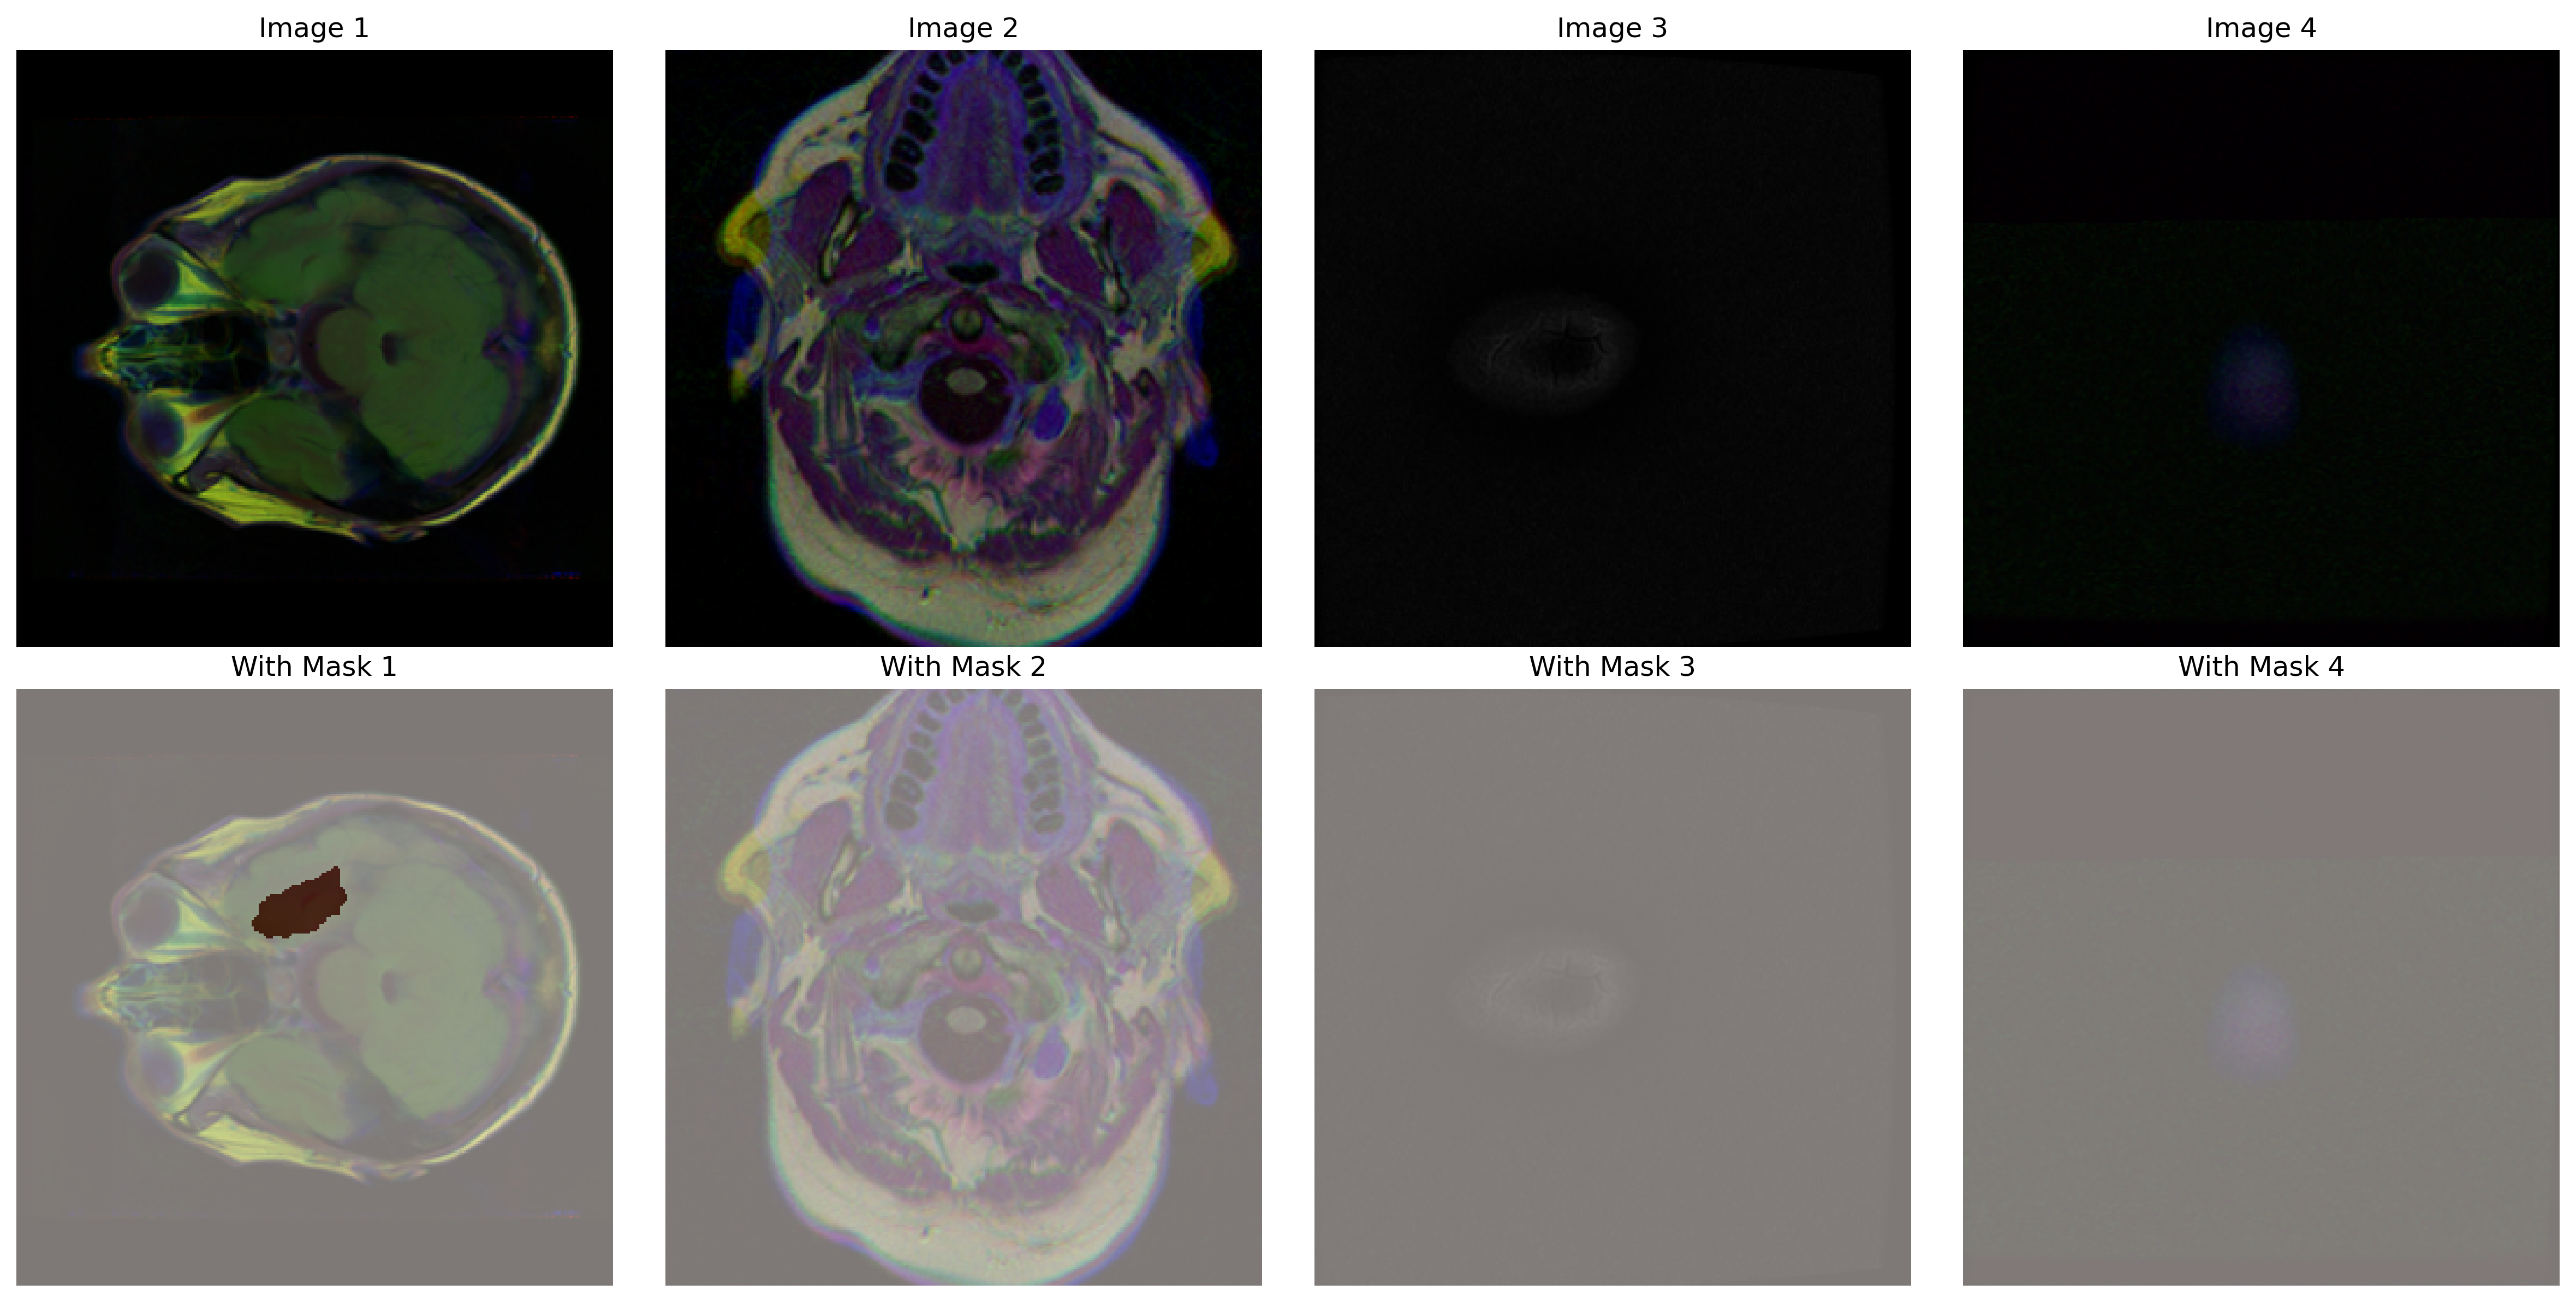

In [3]:
print("\n" + "=" * 70)
print("STEP 2: CREATING PYTORCH DATALOADERS")
print("=" * 70 + "\n")

BATCH_SIZE = 16
TARGET_SIZE = (256, 256)
NUM_WORKERS = 8  # Adjust based on your CPU

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    image_paths, mask_paths,
    train_idx, val_idx, test_idx,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    target_size=TARGET_SIZE
)

# Visualize sample batch
print("\nVisualizing sample batch...")
sample_images, sample_masks = next(iter(train_loader))
print(f"Image batch shape: {sample_images.shape}")  # [B, 3, H, W]
print(f"Mask batch shape: {sample_masks.shape}")    # [B, 1, H, W]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    # Convert from CHW to HWC for display
    img = sample_images[i].permute(1, 2, 0).numpy()
    mask = sample_masks[i][0].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(img)
    axes[1, i].imshow(mask, alpha=0.5, cmap='Reds')
    axes[1, i].set_title(f'With Mask {i+1}')
    axes[1, i].axis('off')
plt.tight_layout()
plt.savefig('results/figures/sample_batch.png', dpi=300, bbox_inches='tight')
plt.show()

## Step 4: Build and Train Baseline Model

Build baseline ResUNet model with α=0.5, β=0.5 Tversky Loss parameters. Train for 30 epochs with Adam optimizer, early stopping, and model checkpointing. Track training and validation Dice scores and loss values.

In [5]:
print("\n" + "=" * 70)
print("STEP 3: TRAINING BASELINE MODEL")
print("=" * 70 + "\n")

# Build baseline model
baseline_model = ResUNet(in_channels=3, out_channels=1, filters_base=16).to(device)
print(f"\nBaseline Model Parameters: {count_parameters(baseline_model):,}")

# Define loss and optimizer
baseline_criterion = TverskyLoss(alpha=0.5, beta=0.5)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=1e-4)

print(f"\nBaseline Configuration:")
print(f"  Tversky Loss: α=0.5, β=0.5")
print(f"  Optimizer: Adam(lr=1e-4)")
print(f"  Batch Size: {BATCH_SIZE}")

# Train baseline model
print("\n🚀 Training Baseline Model...")
baseline_history = train_model(
    baseline_model,
    train_loader,
    val_loader,
    baseline_criterion,
    baseline_optimizer,
    device,
    num_epochs=5,
    patience=10,
    save_path='models/baseline_model.pth'
)

print("\n✓ Baseline model training complete!")
print(f"Best Val Dice: {max(baseline_history['val_dice']):.4f}")


STEP 3: TRAINING BASELINE MODEL


Baseline Model Parameters: 2,031,137

Baseline Configuration:
  Tversky Loss: α=0.5, β=0.5
  Optimizer: Adam(lr=1e-4)
  Batch Size: 16

🚀 Training Baseline Model...
Epoch 1/5
  Train - Loss: 0.9565, Dice: 0.0435, IoU: 0.0224
  Val   - Loss: 0.9293, Dice: 0.0707, IoU: 0.0383
  ✓ Saved best model (Dice: 0.0707)
Epoch 2/5
  Train - Loss: 0.9307, Dice: 0.0693, IoU: 0.0361
  Val   - Loss: 0.9147, Dice: 0.0853, IoU: 0.0470
  ✓ Saved best model (Dice: 0.0853)
Epoch 3/5
  Train - Loss: 0.9074, Dice: 0.0926, IoU: 0.0492
  Val   - Loss: 0.8885, Dice: 0.1115, IoU: 0.0634
  ✓ Saved best model (Dice: 0.1115)
Epoch 4/5
  Train - Loss: 0.8798, Dice: 0.1202, IoU: 0.0649
  Val   - Loss: 0.8690, Dice: 0.1310, IoU: 0.0765
  ✓ Saved best model (Dice: 0.1310)
Epoch 5/5
  Train - Loss: 0.8358, Dice: 0.1642, IoU: 0.0909
  Val   - Loss: 0.8363, Dice: 0.1637, IoU: 0.0998
  ✓ Saved best model (Dice: 0.1637)

✓ Baseline model training complete!
Best Val Dice: 0.1637


## Step 5: Hyperparameter Optimization with Optuna

Define Optuna objective function to optimize alpha, beta, and learning rate parameters. Run TPE sampler-based study with 20 trials, each training for 15 epochs. Extract best hyperparameters and visualize optimization history.

In [7]:
print("\n" + "=" * 70)
print("STEP 4: HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
print("=" * 70 + "\n")

import optuna
from optuna.samplers import TPESampler

def objective(trial):
    """
    Optuna objective function to optimize Tversky Loss parameters.
    """
    # Suggest hyperparameters
    alpha = trial.suggest_float('alpha', 0.1, 0.9)
    beta = trial.suggest_float('beta', 0.1, 0.9)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    
    # Build model
    model = ResUNet(in_channels=3, out_channels=1, filters_base=16).to(device)
    criterion = TverskyLoss(alpha=alpha, beta=beta)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train for fewer epochs during optimization
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        num_epochs=5,  # Reduced for faster optimization
        patience=5,
        save_path=f'models/trial_{trial.number}.pth'
    )
    
    # Return best validation Dice score
    best_dice = max(history['val_dice'])
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    
    return best_dice

# Create and run study
print("🔍 Running Optuna optimization (this may take a while)...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=3, show_progress_bar=True)

# Print results
print("\n" + "=" * 70)
print("OPTUNA OPTIMIZATION RESULTS")
print("=" * 70)
print(f"\nBest Trial: {study.best_trial.number}")
print(f"Best Validation Dice: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value:.4f}")

# Visualize optimization
plot_optuna_optimization(study)

[I 2025-12-10 22:41:19,947] A new study created in memory with name: no-name-b82f6775-c31b-4085-9a14-6752d588848c



STEP 4: HYPERPARAMETER OPTIMIZATION WITH OPTUNA

🔍 Running Optuna optimization (this may take a while)...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/5
  Train - Loss: 0.9693, Dice: 0.0511, IoU: 0.0265
  Val   - Loss: 0.9414, Dice: 0.0919, IoU: 0.0510
  ✓ Saved best model (Dice: 0.0919)
Epoch 2/5
  Train - Loss: 0.9195, Dice: 0.1281, IoU: 0.0698
  Val   - Loss: 0.8726, Dice: 0.1786, IoU: 0.1104
  ✓ Saved best model (Dice: 0.1786)
Epoch 3/5
  Train - Loss: 0.7762, Dice: 0.3119, IoU: 0.1926
  Val   - Loss: 0.7405, Dice: 0.3103, IoU: 0.2225
  ✓ Saved best model (Dice: 0.3103)
Epoch 4/5
  Train - Loss: 0.5379, Dice: 0.5425, IoU: 0.3851
  Val   - Loss: 0.6580, Dice: 0.3647, IoU: 0.2879
  ✓ Saved best model (Dice: 0.3647)


Best trial: 0. Best value: 0.367066:  33%|███▎      | 1/3 [08:35<17:11, 515.74s/it]

Epoch 5/5
  Train - Loss: 0.4225, Dice: 0.6201, IoU: 0.4688
  Val   - Loss: 0.6501, Dice: 0.3671, IoU: 0.2937
  ✓ Saved best model (Dice: 0.3671)
[I 2025-12-10 22:49:55,686] Trial 0 finished with value: 0.36706593198521215 and parameters: {'alpha': 0.39963209507789, 'beta': 0.8605714451279329, 'learning_rate': 0.000291063591313307}. Best is trial 0 with value: 0.36706593198521215.
Epoch 1/5
  Train - Loss: 0.9440, Dice: 0.0264, IoU: 0.0134
  Val   - Loss: 0.9181, Dice: 0.0410, IoU: 0.0214
  ✓ Saved best model (Dice: 0.0410)
Epoch 2/5
  Train - Loss: 0.9276, Dice: 0.0343, IoU: 0.0175
  Val   - Loss: 0.9097, Dice: 0.0456, IoU: 0.0240
  ✓ Saved best model (Dice: 0.0456)
Epoch 3/5
  Train - Loss: 0.9201, Dice: 0.0380, IoU: 0.0194
  Val   - Loss: 0.9028, Dice: 0.0494, IoU: 0.0261
  ✓ Saved best model (Dice: 0.0494)
Epoch 4/5
  Train - Loss: 0.9148, Dice: 0.0407, IoU: 0.0209
  Val   - Loss: 0.8993, Dice: 0.0514, IoU: 0.0272
  ✓ Saved best model (Dice: 0.0514)


Best trial: 0. Best value: 0.367066:  67%|██████▋   | 2/3 [17:04<08:31, 511.89s/it]

Epoch 5/5
  Train - Loss: 0.9096, Dice: 0.0434, IoU: 0.0223
  Val   - Loss: 0.8956, Dice: 0.0535, IoU: 0.0284
  ✓ Saved best model (Dice: 0.0535)
[I 2025-12-10 22:58:24,881] Trial 1 finished with value: 0.053529696229284836 and parameters: {'alpha': 0.5789267873576293, 'beta': 0.22481491235394924, 'learning_rate': 2.0511104188433963e-05}. Best is trial 0 with value: 0.36706593198521215.
Epoch 1/5
  Train - Loss: 0.9578, Dice: 0.0643, IoU: 0.0337
  Val   - Loss: 0.9260, Dice: 0.1058, IoU: 0.0601
  ✓ Saved best model (Dice: 0.1058)
Epoch 2/5
  Train - Loss: 0.9065, Dice: 0.1373, IoU: 0.0753
  Val   - Loss: 0.8794, Dice: 0.1585, IoU: 0.0969
  ✓ Saved best model (Dice: 0.1585)
Epoch 3/5
  Train - Loss: 0.8262, Dice: 0.2391, IoU: 0.1401
  Val   - Loss: 0.8049, Dice: 0.2409, IoU: 0.1611
  ✓ Saved best model (Dice: 0.2409)
Epoch 4/5
  Train - Loss: 0.6854, Dice: 0.3917, IoU: 0.2513
  Val   - Loss: 0.7158, Dice: 0.3146, IoU: 0.2313
  ✓ Saved best model (Dice: 0.3146)


Best trial: 2. Best value: 0.370652: 100%|██████████| 3/3 [25:43<00:00, 514.54s/it]

Epoch 5/5
  Train - Loss: 0.5156, Dice: 0.5328, IoU: 0.3778
  Val   - Loss: 0.6373, Dice: 0.3707, IoU: 0.2890
  ✓ Saved best model (Dice: 0.3707)
[I 2025-12-10 23:07:03,554] Trial 2 finished with value: 0.37065226448128274 and parameters: {'alpha': 0.14646688973455957, 'beta': 0.7929409166199481, 'learning_rate': 0.00015930522616241006}. Best is trial 2 with value: 0.37065226448128274.

OPTUNA OPTIMIZATION RESULTS

Best Trial: 2
Best Validation Dice: 0.3707

Best Parameters:
  alpha: 0.1465
  beta: 0.7929
  learning_rate: 0.0002


✓ Saved Optuna optimization plot to results/figures/optuna_optimization.png


## Step 6: Train Optimized Model with Best Parameters

Build and train new ResUNet model using best hyperparameters from Optuna. Train for 30 epochs with same training protocol as baseline. Compare validation performance metrics.

In [8]:
print("\n" + "=" * 70)
print("STEP 5: TRAINING OPTIMIZED MODEL")
print("=" * 70 + "\n")

# Extract best parameters
best_alpha = study.best_params['alpha']
best_beta = study.best_params['beta']
best_lr = study.best_params['learning_rate']

print(f"Using optimized parameters:")
print(f"  Alpha: {best_alpha:.4f}")
print(f"  Beta: {best_beta:.4f}")
print(f"  Learning Rate: {best_lr:.6f}")

# Build and train optimized model
optimized_model = ResUNet(in_channels=3, out_channels=1, filters_base=16).to(device)
optimized_criterion = TverskyLoss(alpha=best_alpha, beta=best_beta)
optimized_optimizer = optim.Adam(optimized_model.parameters(), lr=best_lr)

print("\n🚀 Training Optimized Model...")
optimized_history = train_model(
    optimized_model,
    train_loader,
    val_loader,
    optimized_criterion,
    optimized_optimizer,
    device,
    num_epochs=5,
    patience=10,
    save_path='models/optimized_model.pth'
)

print("\n✓ Optimized model training complete!")
print(f"Best Val Dice: {max(optimized_history['val_dice']):.4f}")


STEP 5: TRAINING OPTIMIZED MODEL

Using optimized parameters:
  Alpha: 0.1465
  Beta: 0.7929
  Learning Rate: 0.000159

🚀 Training Optimized Model...
Epoch 1/5
  Train - Loss: 0.9756, Dice: 0.0380, IoU: 0.0195
  Val   - Loss: 0.9626, Dice: 0.0562, IoU: 0.0300
  ✓ Saved best model (Dice: 0.0562)
Epoch 2/5
  Train - Loss: 0.9656, Dice: 0.0532, IoU: 0.0275
  Val   - Loss: 0.9558, Dice: 0.0659, IoU: 0.0355
  ✓ Saved best model (Dice: 0.0659)
Epoch 3/5
  Train - Loss: 0.9541, Dice: 0.0702, IoU: 0.0367
  Val   - Loss: 0.9461, Dice: 0.0793, IoU: 0.0436
  ✓ Saved best model (Dice: 0.0793)
Epoch 4/5
  Train - Loss: 0.9346, Dice: 0.0988, IoU: 0.0526
  Val   - Loss: 0.9242, Dice: 0.1074, IoU: 0.0610
  ✓ Saved best model (Dice: 0.1074)
Epoch 5/5
  Train - Loss: 0.8991, Dice: 0.1488, IoU: 0.0814
  Val   - Loss: 0.8870, Dice: 0.1542, IoU: 0.0928
  ✓ Saved best model (Dice: 0.1542)

✓ Optimized model training complete!
Best Val Dice: 0.1542


## Step 7: Compare Training Histories

Plot training and validation loss/Dice curves for both baseline and optimized models. Calculate absolute and relative improvement percentages. Visualize performance gains across epochs.

In [9]:
print("\n" + "=" * 70)
print("STEP 6: COMPARING TRAINING HISTORIES")
print("=" * 70 + "\n")

plot_training_history(baseline_history, optimized_history)

# Print comparison
baseline_final = baseline_history['val_dice'][-1]
optimized_final = optimized_history['val_dice'][-1]
improvement = ((optimized_final - baseline_final) / baseline_final) * 100

print(f"\nFinal Validation Dice Scores:")
print(f"  Baseline:  {baseline_final:.4f}")
print(f"  Optimized: {optimized_final:.4f}")
print(f"  Improvement: {improvement:+.2f}%")


STEP 6: COMPARING TRAINING HISTORIES

✓ Saved training curves to results/figures/training_curves.png

Final Validation Dice Scores:
  Baseline:  0.1637
  Optimized: 0.1542
  Improvement: -5.83%


## Step 8: Evaluate on Test Set

Load saved model checkpoints and evaluate both baseline and optimized models on held-out test set. Calculate Dice coefficient, IoU, and loss metrics. Compute per-sample Dice scores for statistical analysis.

In [10]:
print("\n" + "=" * 70)
print("STEP 7: TEST SET EVALUATION")
print("=" * 70 + "\n")

# Load best models
baseline_checkpoint = torch.load('models/baseline_model.pth')
baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])

optimized_checkpoint = torch.load('models/optimized_model.pth')
optimized_model.load_state_dict(optimized_checkpoint['model_state_dict'])

# Evaluate both models
print("Evaluating Baseline Model on Test Set...")
baseline_test_metrics = validate(baseline_model, test_loader, baseline_criterion, device)

print("Evaluating Optimized Model on Test Set...")
optimized_test_metrics = validate(optimized_model, test_loader, optimized_criterion, device)

# Print results
print("\n" + "=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print("\nBaseline Model:")
print(f"  Loss: {baseline_test_metrics['loss']:.4f}")
print(f"  Dice Coefficient: {baseline_test_metrics['dice']:.4f}")
print(f"  IoU Coefficient: {baseline_test_metrics['iou']:.4f}")

print("\nOptimized Model:")
print(f"  Loss: {optimized_test_metrics['loss']:.4f}")
print(f"  Dice Coefficient: {optimized_test_metrics['dice']:.4f}")
print(f"  IoU Coefficient: {optimized_test_metrics['iou']:.4f}")

# Calculate per-sample Dice scores
print("\nCalculating per-sample Dice scores...")
baseline_dice_scores = calculate_dice_per_sample(baseline_model, test_loader, device)
optimized_dice_scores = calculate_dice_per_sample(optimized_model, test_loader, device)

print(f"✓ Calculated Dice scores for {len(baseline_dice_scores)} test samples")


STEP 7: TEST SET EVALUATION

Evaluating Baseline Model on Test Set...
Evaluating Optimized Model on Test Set...

TEST SET RESULTS

Baseline Model:
  Loss: 0.8295
  Dice Coefficient: 0.1705
  IoU Coefficient: 0.1039

Optimized Model:
  Loss: 0.8899
  Dice Coefficient: 0.1482
  IoU Coefficient: 0.0889

Calculating per-sample Dice scores...
✓ Calculated Dice scores for 561 test samples


## Step 9: Visual Comparison - The Contest

Create side-by-side segmentation visualizations comparing baseline vs optimized model predictions on test samples. Display original images, ground truth masks, and model predictions with Dice scores for visual inspection.

In [11]:
print("\n" + "=" * 70)
print("STEP 8: VISUAL COMPARISON - THE CONTEST")
print("=" * 70 + "\n")

# Create contest visualization
contest_dice_baseline, contest_dice_optimized = visualize_segmentation_contest(
    baseline_model,
    optimized_model,
    test_loader,
    device,
    num_samples=5
)

print("\nContest Sample Results:")
for i, (db, do) in enumerate(zip(contest_dice_baseline, contest_dice_optimized)):
    improvement = do - db
    symbol = "↑" if improvement > 0 else "↓"
    print(f"  Sample {i+1}: Baseline={db:.4f}, Optimized={do:.4f} {symbol} {abs(improvement):.4f}")


STEP 8: VISUAL COMPARISON - THE CONTEST

✓ Saved contest visualization to results/figures/contest_results.png

Contest Sample Results:
  Sample 1: Baseline=0.3816, Optimized=0.0000 ↓ 0.3816
  Sample 2: Baseline=0.7172, Optimized=0.7019 ↓ 0.0153
  Sample 3: Baseline=0.8299, Optimized=0.8415 ↑ 0.0116
  Sample 4: Baseline=0.8350, Optimized=0.8387 ↑ 0.0037
  Sample 5: Baseline=0.8935, Optimized=0.8977 ↑ 0.0042


## Step 10: Statistical Comparison

Perform paired t-test on per-sample Dice scores. Calculate mean, median, min/max Dice values with standard deviations for both models. Determine statistical significance of improvements with p-value analysis.

In [12]:
print("\n" + "=" * 70)
print("STEP 9: STATISTICAL COMPARISON")
print("=" * 70 + "\n")

# Create boxplot comparison
plot_model_comparison_boxplot(baseline_dice_scores, optimized_dice_scores)

# Statistical tests
from scipy import stats

# Paired t-test
t_stat, p_value = stats.ttest_rel(baseline_dice_scores, optimized_dice_scores)

print("Statistical Analysis:")
print(f"\nBaseline Model:")
print(f"  Mean Dice: {np.mean(baseline_dice_scores):.4f} ± {np.std(baseline_dice_scores):.4f}")
print(f"  Median Dice: {np.median(baseline_dice_scores):.4f}")
print(f"  Min/Max: {np.min(baseline_dice_scores):.4f} / {np.max(baseline_dice_scores):.4f}")

print(f"\nOptimized Model:")
print(f"  Mean Dice: {np.mean(optimized_dice_scores):.4f} ± {np.std(optimized_dice_scores):.4f}")
print(f"  Median Dice: {np.median(optimized_dice_scores):.4f}")
print(f"  Min/Max: {np.min(optimized_dice_scores):.4f} / {np.max(optimized_dice_scores):.4f}")

print(f"\nPaired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")

if p_value < 0.05:
    print("  ✓ Statistically significant improvement (p < 0.05)")
else:
    print("  ✗ Not statistically significant (p >= 0.05)")

improvement_pct = ((np.mean(optimized_dice_scores) - np.mean(baseline_dice_scores)) / 
                   np.mean(baseline_dice_scores) * 100)
print(f"\nOverall Improvement: {improvement_pct:+.2f}%")


STEP 9: STATISTICAL COMPARISON

✓ Saved model comparison boxplot to results/figures/model_comparison.png
Statistical Analysis:

Baseline Model:
  Mean Dice: 0.6755 ± 0.4083
  Median Dice: 0.8846
  Min/Max: 0.0000 / 1.0000

Optimized Model:
  Mean Dice: 0.5819 ± 0.4371
  Median Dice: 0.8044
  Min/Max: 0.0000 / 1.0000

Paired t-test:
  t-statistic: 6.4187
  p-value: 2.9313e-10
  ✓ Statistically significant improvement (p < 0.05)

Overall Improvement: -13.87%


## Step 11: Save Results Summary

Generate comprehensive results report including dataset statistics, baseline and optimized model metrics, performance improvements, best hyperparameters, and model architecture details. Save summary to text file.

In [14]:
print("\n" + "=" * 70)
print("STEP 10: SAVING RESULTS SUMMARY")
print("=" * 70 + "\n")

# Create summary report
summary = f"""
BRAIN TUMOR SEGMENTATION PROJECT - RESULTS SUMMARY (PyTorch)
{'=' * 70}

Dataset Statistics:
  Total Patients: {len(patient_groups)}
  Total Slices: {len(image_paths)}
  Train: {len(train_patients)} patients, {len(train_idx)} slices
  Validation: {len(val_patients)} patients, {len(val_idx)} slices
  Test: {len(test_patients)} patients, {len(test_idx)} slices

Baseline Model (α=0.5, β=0.5):
  Validation Dice: {max(baseline_history['val_dice']):.4f}
  Test Dice: {baseline_test_metrics['dice']:.4f}
  Test IoU: {baseline_test_metrics['iou']:.4f}
  Mean Test Dice (per-sample): {np.mean(baseline_dice_scores):.4f} ± {np.std(baseline_dice_scores):.4f}

Optimized Model (α={best_alpha:.4f}, β={best_beta:.4f}):
  Validation Dice: {max(optimized_history['val_dice']):.4f}
  Test Dice: {optimized_test_metrics['dice']:.4f}
  Test IoU: {optimized_test_metrics['iou']:.4f}
  Mean Test Dice (per-sample): {np.mean(optimized_dice_scores):.4f} ± {np.std(optimized_dice_scores):.4f}

Performance Improvement:
  Absolute: {np.mean(optimized_dice_scores) - np.mean(baseline_dice_scores):+.4f}
  Relative: {improvement_pct:+.2f}%
  Statistical Significance: {'Yes (p < 0.05)' if p_value < 0.05 else 'No (p >= 0.05)'}
  p-value: {p_value:.4e}

Best Hyperparameters Found (Optuna):
  Alpha: {best_alpha:.4f}
  Beta: {best_beta:.4f}
  Learning Rate: {best_lr:.6f}
  Number of Trials: {len(study.trials)}

Model Architecture:
  Framework: PyTorch
  Total Parameters: {count_parameters(baseline_model):,}
  Device: {device}

{'=' * 70}
"""

# Save summary
with open('results/results_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(summary)
print("✓ Results summary saved to results/results_summary.txt")


STEP 10: SAVING RESULTS SUMMARY


BRAIN TUMOR SEGMENTATION PROJECT - RESULTS SUMMARY (PyTorch)

Dataset Statistics:
  Total Patients: 110
  Total Slices: 3929
  Train: 77 patients, 2750 slices
  Validation: 16 patients, 618 slices
  Test: 17 patients, 561 slices

Baseline Model (α=0.5, β=0.5):
  Validation Dice: 0.1637
  Test Dice: 0.1705
  Test IoU: 0.1039
  Mean Test Dice (per-sample): 0.6755 ± 0.4083

Optimized Model (α=0.1465, β=0.7929):
  Validation Dice: 0.1542
  Test Dice: 0.1482
  Test IoU: 0.0889
  Mean Test Dice (per-sample): 0.5819 ± 0.4371

Performance Improvement:
  Absolute: -0.0937
  Relative: -13.87%
  Statistical Significance: Yes (p < 0.05)
  p-value: 2.9313e-10

Best Hyperparameters Found (Optuna):
  Alpha: 0.1465
  Beta: 0.7929
  Learning Rate: 0.000159
  Number of Trials: 3

Model Architecture:
  Framework: PyTorch
  Total Parameters: 2,031,137
  Device: cuda


✓ Results summary saved to results/results_summary.txt


## Final Remarks

Project completion with summary of all generated outputs including trained models, publication-ready figures, and results summary.

In [15]:
print("\n" + "=" * 70)
print("PROJECT COMPLETE!")
print("=" * 70 + "\n")

print("Generated Outputs:")
print("  📁 models/")
print("     ├── baseline_model.pth")
print("     └── optimized_model.pth")
print("  📁 results/figures/")
print("     ├── patient_split.png")
print("     ├── slice_distribution.png")
print("     ├── sample_batch.png")
print("     ├── optuna_optimization.png")
print("     ├── training_curves.png")
print("     ├── contest_results.png")
print("     └── model_comparison.png")
print("  📁 results/")
print("     └── results_summary.txt")

print("\n🎉 All figures are publication-ready!")
print("🔬 Use these results for your research paper or presentation.")

# Optional: Load saved models
# checkpoint = torch.load('models/baseline_model.pth')
# model = ResUNet(in_channels=3, out_channels=1, filters_base=32)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)


PROJECT COMPLETE!

Generated Outputs:
  📁 models/
     ├── baseline_model.pth
     └── optimized_model.pth
  📁 results/figures/
     ├── patient_split.png
     ├── slice_distribution.png
     ├── sample_batch.png
     ├── optuna_optimization.png
     ├── training_curves.png
     ├── contest_results.png
     └── model_comparison.png
  📁 results/
     └── results_summary.txt

🎉 All figures are publication-ready!
🔬 Use these results for your research paper or presentation.
